# Week 3 Mini-Assignment Testing and Environment Setup

This assignment is the second part of your two-week project. You will now focus on making your data analysis project reproducible and testable. You’ll write basic unit tests for your data analysis functions and set up a development environment using either Dev Container or Docker. It should be in the same Github Repository you created last week.

In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

Import the Dataset


In [ ]:
DATA_PATH = "all_commodities_data.csv"
df = pd.read_csv(DATA_PATH)

Column Descriptions:

    Date: The date the data was recorded. Format YYYY-MM-DD.
    Open: Market opening price.
    High: Highest price during the trading day.
    Low: Lowest price during the trading day.
    Close: Market closing price.
    Volume: Number of contracts traded during the day.
    Ticker: Market quotation symbol for the future.
    Commodity: Name of the precious metal the future refers to.


Inspect the Data

    E.g., Display the first few rows using .head() to get a quick overview.
    E.g., Use .info() and .describe() to understand data types and summary statistics.
    E.g., Check for missing values and duplicates (optional).



In [ ]:
df.head(10) # display the first 10 rows

In [ ]:
df.info() # information on column datatypes, there are no nulls

In [ ]:
df.describe() # descriptive statistics

In [ ]:
df.shape

In [ ]:
print(df['ticker'].unique())
print(df['commodity'].unique())

Basic Filtering and Grouping

    Apply filters to extract meaningful subsets of the data.
    Use groupby() or equivalent on a selected variable and compute summary statistics (e.g., mean, count).


In [ ]:
# group by year
df['date'] = pd.to_datetime(df['date']) # convert to datetime
df['year'] = df['date'].dt.year

# Group by year and aggregate (example: mean close price per year)
grouped = df.groupby('year').agg({
    'open': 'mean',
    'high': 'mean',
    'low': 'mean',
    'close': 'mean',
    'volume': 'sum'
}).reset_index()

print(grouped)

In [ ]:
# Group by commodity
grouped = df.groupby('commodity').agg({
    'open': 'mean',
    'high': 'mean',
    'low': 'mean',
    'close': 'mean',
    'volume': 'sum'
}).reset_index()

print(grouped)

In [ ]:
# Group by Gold per year
gold_df = df[df['commodity'] == 'Gold'].copy()

gold_df['date'] = pd.to_datetime(gold_df['date'])
gold_df['year'] = gold_df['date'].dt.year

gold_grouped = gold_df.groupby('year').agg({
    'open': 'mean',
    'high': 'mean',
    'low': 'mean',
    'close': 'mean',
    'volume': 'sum'
}).reset_index()

print(gold_grouped)

Explore a Machine Learning Algorithm

    Choose an ML algorithm.
    Begin experimenting with model inputs and outputs.


In [ ]:
gold_df.head()

> Predicting ext day open price  for Gold based on previous 5 days.


=== Model Performance ===
Metric      Value
  RMSE 169.320814
    R²   0.142741


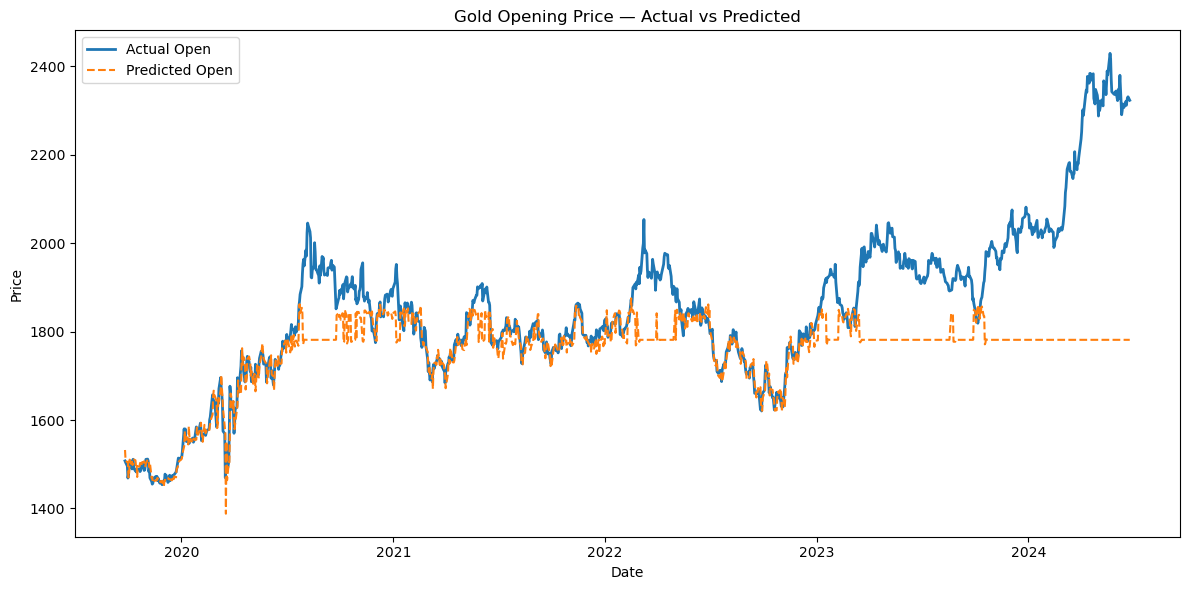

In [31]:
n_lags = 5  # # Create lag features for OPEN only
for lag in range(1, n_lags + 1):
    gold_df[f'open_lag_{lag}'] = gold_df['open'].shift(lag)

keep_cols = ['date', 'open'] + [c for c in gold_df.columns if c.startswith('open_lag_')]
gold_df = gold_df[keep_cols].dropna()

# Train/test
X = gold_df.drop(columns=['date', 'open'])
y = gold_df['open']
split_idx = int(len(X) * 0.8)  # 80/20 split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = gold_df['date'].iloc[split_idx:]  # for plotting

# Train
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    random_state=42
)
gbr.fit(X_train, y_train)

# Evaluate
y_pred = gbr.predict(X_test)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = float(r2_score(y_test, y_pred))

results_table = pd.DataFrame({
    "Metric": ["RMSE", "R²"],
    "Value": [rmse, r2]
})
print("\n=== Model Performance ===")
print(results_table.to_string(index=False))

# Visualize
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test.values, label="Actual Open", linewidth=2)
plt.plot(dates_test, y_pred, "--", label="Predicted Open")
plt.title("Gold Opening Price — Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

    This model performs poorly. Visualization shows it can follow trends in a general sense, but there are many sections where the model completely breaks down (reflected by the high RMSE).

> Predicting change (up or down) based on performance of previous day

In [ ]:
gold_df = df[df['commodity'] == 'Gold'].copy() # Group by Gold per year
gold_df['date'] = pd.to_datetime(gold_df['date'])
gold_df['year'] = gold_df['date'].dt.year

gold_df = gold_df.drop(columns=['ticker','commodity','high','low','volume','year', 'open'])

gold_df['change'] = gold_df['close'].diff().apply(lambda x: 'up' if x > 0 else 'down') # Create the 'change' column based on price movement from previous day
gold_df = gold_df.drop(gold_df.index[0]) # Drop the first row (since it doesn't have a previous day to compare to)
gold_df = gold_df.reset_index(drop=True)

# Create features for the model
def create_features(df):
    df = df.copy()
    
    # Only 2 key predictors
    df['ma_7'] = df['close'].rolling(window=7).mean()
    df['price_vs_ma7'] = (df['close'] - df['ma_7']) / df['ma_7']  # Position vs 7-day MA
    df['price_change_5d'] = df['close'].pct_change(5)  # 5-day percentage change
    
    return df

# Prepare the data
gold_df_features = create_features(gold_df)
gold_df_features['target'] = gold_df_features['change'].shift(-1) # Create target variable (next day's direction)
gold_df_features = gold_df_features.dropna() # Drop rows with missing values
feature_columns = ['price_vs_ma7', 'price_change_5d'] # Select only 2 features

X = gold_df_features[feature_columns]
y = gold_df_features['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Split the data
scaler = StandardScaler() # Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42) # Train the model
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled) # Make predictions

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['down', 'up'])

print(f"\nModel Accuracy: {accuracy:.3f}")

# Extract TP, TN, FP, FN from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN - correctly predicted 'down'): {tn}")
print(f"False Positives (FP - predicted 'up', actually 'down'): {fp}")
print(f"False Negatives (FN - predicted 'down', actually 'up'): {fn}")
print(f"True Positives (TP - correctly predicted 'up'): {tp}")


Model Accuracy: 0.530

Confusion Matrix Breakdown:
True Negatives (TN - correctly predicted 'down'): 35
False Positives (FP - predicted 'up', actually 'down'): 818
False Negatives (FN - predicted 'down', actually 'up'): 23
True Positives (TP - correctly predicted 'up'): 915


    This model performs better than the previous. I believe this is due to a narrower scope of what it is predicting i.e. direction change vs. price point. It is, however, too biased in calling upwards movements than downward movements. This is likely because it uses previous movements as a predictor, and the price of gold genereally rises over the 24 years, so when the price suddenly drops, the model struggles to adapt accordingly.

Visualization

    Create one plot (e.g., histogram, boxplot, scatter plot) using Matplotlib, Seaborn, or others.


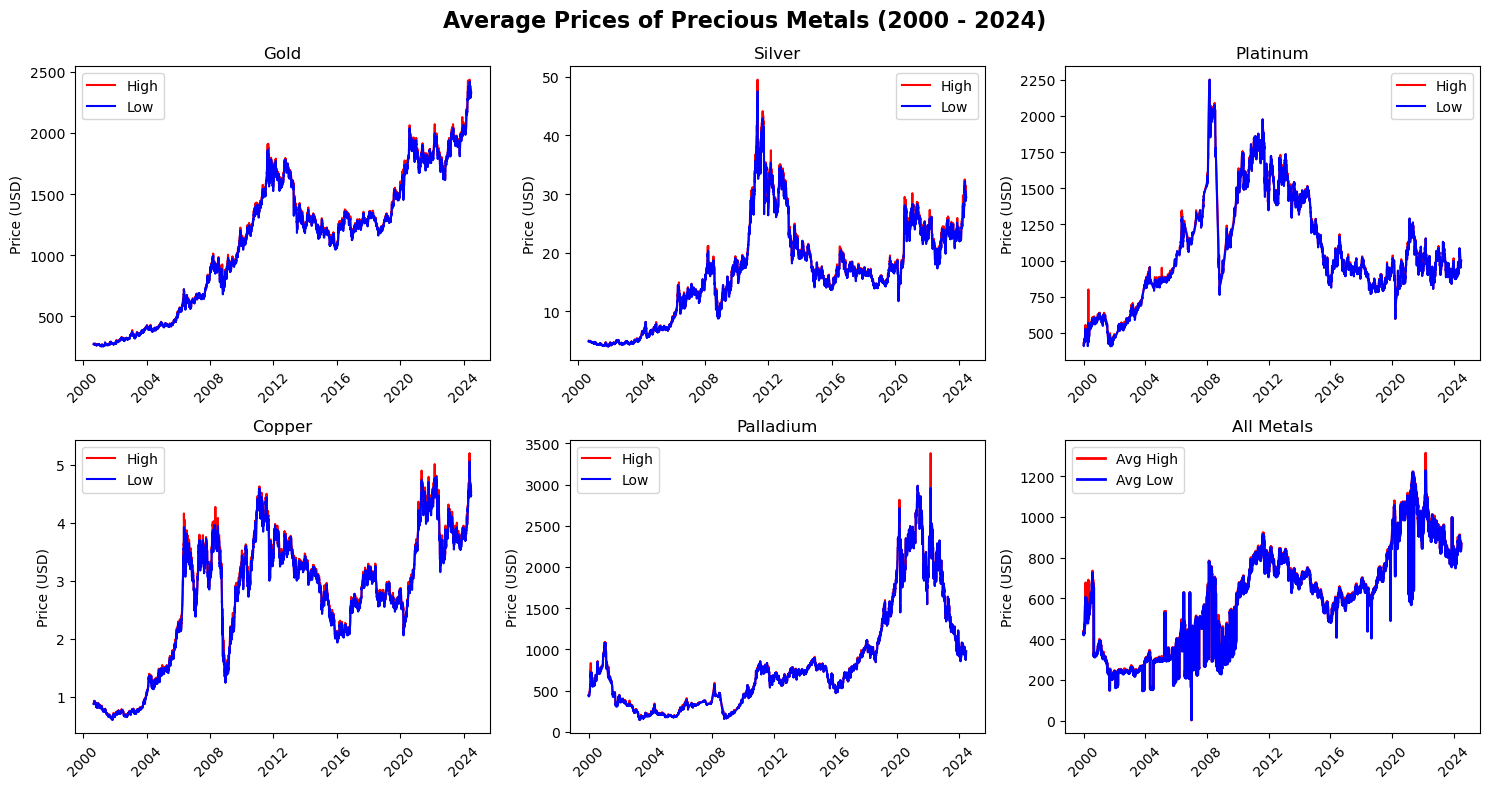

In [36]:
df['date'] = pd.to_datetime(df['date'])
commodities = df['commodity'].unique()

# Remove sharex=True to allow individual x-axis labels
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes_flat = axes.flatten()

# Plot first 5 commodities
for i, commodity in enumerate(commodities):
    if i < 5:  # Plot first 5 commodities in first 5 subplots
        ax = axes_flat[i]
        sub_df = df[df['commodity'] == commodity]
        ax.plot(sub_df['date'], sub_df['high'], label="High", color="red")
        ax.plot(sub_df['date'], sub_df['low'], label="Low", color="blue")
        ax.set_title(f"{commodity}")
        ax.set_ylabel("Price (USD)")
        ax.legend()
        
        # Format x-axis to show years
        ax.xaxis.set_major_locator(mdates.YearLocator(base=4))  # Every 4 years
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.tick_params(axis='x', rotation=45)

# Average for all metals in the 6th subplot
if len(axes_flat) >= 6:
    ax = axes_flat[5]  # 6th subplot (index 5)
    avg_data = df.groupby('date')[['high', 'low']].mean().reset_index()
    ax.plot(avg_data['date'], avg_data['high'], label="Avg High", color="red", linewidth=2)
    ax.plot(avg_data['date'], avg_data['low'], label="Avg Low", color="blue", linewidth=2)
    ax.set_title("All Metals")
    ax.set_ylabel("Price (USD)")
    ax.legend()
    
    # Format x-axis for the average plot as well
    ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Average Prices of Precious Metals (2000 - 2024)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

    Here we see the average prices for each of the metals, and the average for all in the 6th (bottom right) subplot.  Most metals generally increased in price over the years, with the peak for Gold, Platinum and Silver falling between 2008 and 2012. Palladium peaked between 2020 and 2024, and copper peaked closer to 2024.